In [1]:
from models.tf.dataset import StockDataGenerator
from models.tf.models import LongShortTermMemory

Epoch 1/50


2022-10-03 19:22:29.613837: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-03 19:22:30.477938: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-03 19:22:30.522202: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-03 19:22:30.569472: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-03 19:22:30.605011: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-03 19:22:30.665907: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-03 19:22:30.680099: I tensorflow/core/grappler/optimizers/cust

3/6 [==============>...............] - ETA: 0s - loss: 0.4875 - mse: 1.0916 - mae: 0.8811 - rmse: 1.0448

2022-10-03 19:22:31.110707: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - ETA: 0s - loss: 0.4625 - mse: 1.0298 - mae: 0.8550 - rmse: 1.0148

2022-10-03 19:22:32.121524: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-03 19:22:32.422357: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-03 19:22:32.462402: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-03 19:22:32.500006: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-03 19:22:32.510152: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-03 19:22:32.569959: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-03 19:22:32.580234: I tensorflow/core/grappler/optimizers/cust


Epoch 00001: saving model to models/tf/checkpoints/model.01-0.4625.h5
6/6 [==============================] - 5s 324ms/step - loss: 0.4625 - mse: 1.0298 - mae: 0.8550 - rmse: 1.0148 - val_loss: 1.1563 - val_mse: 2.7693 - val_mae: 1.6563 - val_rmse: 1.6641
Epoch 2/50
6/6 [==============================] - ETA: 0s - loss: 0.4328 - mse: 0.9516 - mae: 0.8215 - rmse: 0.9755
Epoch 00002: saving model to models/tf/checkpoints/model.02-0.4328.h5
6/6 [==============================] - 0s 80ms/step - loss: 0.4328 - mse: 0.9516 - mae: 0.8215 - rmse: 0.9755 - val_loss: 1.0772 - val_mse: 2.5103 - val_mae: 1.5772 - val_rmse: 1.5844
Epoch 3/50
5/6 [========================>.....] - ETA: 0s - loss: 0.3906 - mse: 0.8452 - mae: 0.7743 - rmse: 0.9194
Epoch 00003: saving model to models/tf/checkpoints/model.03-0.3788.h5
6/6 [==============================] - 0s 66ms/step - loss: 0.3788 - mse: 0.8160 - mae: 0.7593 - rmse: 0.9033 - val_loss: 0.9124 - val_mse: 2.0121 - val_mae: 1.4124 - val_rmse: 1.4185
Epoc

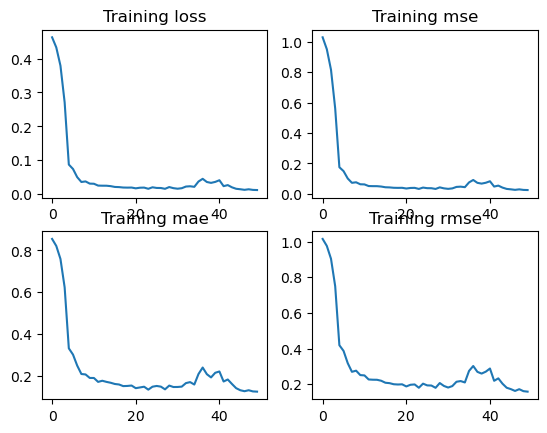

In [5]:
data = StockDataGenerator(
            'BLK', 
            data_path='data/TDA/example.csv',
            verbose=1, target='close'
        )
lstm = LongShortTermMemory(target='close')
lstm.compile_model(data.X_train, verbose=0)
lstm.train_model(
    data.X_train, data.y_train, 
    X_val=data.X_test, y_val=data.y_test, 
    plot_metrics=True, epochs=50, verbose=1
)

In [3]:
lstm.test_model(data.X_test, data.y_test, 1)

2/2 [==============================] - 0s 17ms/step - loss: 0.0049 - mse: 0.0099 - mae: 0.0778 - rmse: 0.0995
